In [0]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize

from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn import svm
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score

from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

Read the data

In [0]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/My Drive/Colab Notebooks") 
with open('ctg.csv') as f:
  print(f.readline())
CTG = pd.read_csv('ctg.csv')

In [0]:
x = CTG.iloc[0:2126:,1:29]
y = CTG.iloc[0:2126:,-1]
y = label_binarize(y, classes=[1,2,3])
x_train, x_test, y_train, y_test = train_test_split(x, y,stratify=y,test_size=0.3, random_state=0)

PCA

In [0]:
x_train_scaled = sklearn.preprocessing.scale(x_train)
x_test_scaled = sklearn.preprocessing.scale(x_test)
sns.set()
pca = PCA().fit(x_train_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
np.cumsum(pca.explained_variance_ratio_)
sns.set()
pca = PCA().fit(x_train)
#plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.plot(pca.explained_variance_)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
pcamodol = PCA(n_components=10)
pcamodol.fit(x_train_scaled)
X_reduced1 = pcamodol.transform(x_train_scaled)
X_reduced2 = pcamodol.transform(x_test_scaled) 

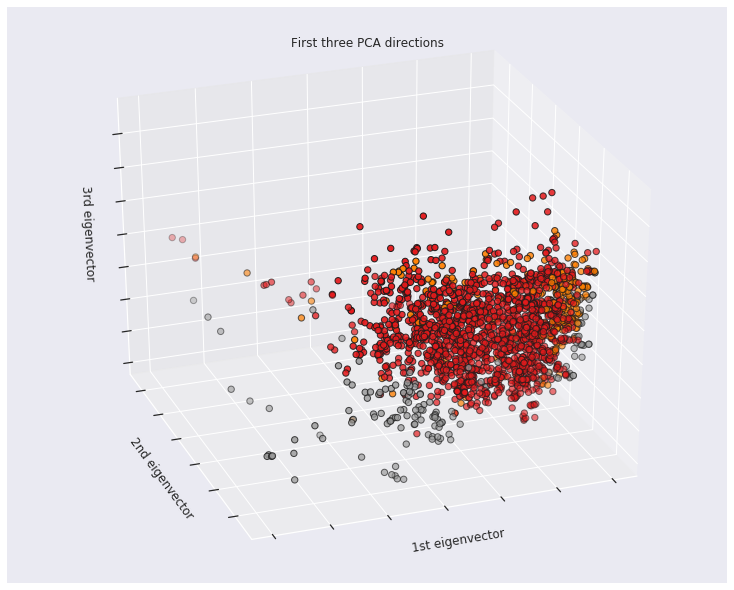

In [0]:
fig = plt.figure(1, figsize=(10, 8))
ax = Axes3D(fig, elev=-150, azim=110)  
X_reduced = PCA(n_components=10).fit_transform(x)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=y,
           cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

plt.show()

Gridsearch tuning hyperparameter

SVM

In [0]:
# Set the parameters by cross-validation
svmparameters = {
    'estimator__kernel': ['rbf', 'linear'],  
    'estimator__C': [0.01, 0.1, 0.5, 1, 2],
    'estimator__gamma': [0.5, 1, 5, 10]
    }

svmcv = GridSearchCV(OneVsRestClassifier(svm.SVC(probability=True)),param_grid = svmparameters,n_jobs=-1,verbose=2,cv=10,scoring='roc_auc')
svmcv.fit(x_train, y_train)
print(svmcv.best_score_)
print(svmcv.best_params_)

In [0]:
modsvm = OneVsRestClassifier(svm.SVC(C = 1, gamma = 0.5, kernel = 'linear', probability=True))   
svmscore = modsvm.fit(X_reduced1, y_train).predict_proba(X_reduced2)
svmyhat = modsvm.fit(X_reduced1, y_train).predict(X_reduced2)
classes = [1, 2, 3]
svmyhat1 = svmyhat.dot(classes)
y_test1 = y_test.dot(classes)
cohen_kappa_score(y_test1,svmyhat1)

In [0]:
fpr_rf= dict()
tpr_rf= dict()
roc_auc_rf = dict()
for i in range(n_classes):
    fpr_rf[i], tpr_rf[i], _ = roc_curve(y_test[:, i], svmscore[:, i])
    roc_auc_rf[i] = auc(fpr_rf[i], tpr_rf[i])
    
# Compute micro-average ROC curve and ROC area (method 1)
fpr_rf["macro"], tpr_rf["macro"], _ = roc_curve(y_test.ravel(), svmscore.ravel())
roc_auc_rf["macro"] = auc(fpr_rf["macro"], tpr_rf["macro"])

lw=2
plt.figure()
plt.plot(fpr_rf["macro"], tpr_rf["macro"],
         label='Average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc_rf["macro"]),
         color='deeppink', linestyle=':', linewidth=4)


colors = cycle(['aqua', 'darkorange', 'cornflowerblue', '#FF6347','#00FF7F'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr_rf[i], tpr_rf[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc_rf[i]))
   

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of SVM for test data')
plt.legend(loc="lower right",prop = {'size':8})
plt.show()

Random Forest

In [0]:
# Set the parameters by cross-validation
rbparameters = {
    'estimator__n_estimators': [2, 5, 10, 30],
    'estimator__max_depth': [5, 10, 20, 50]
    }

rbcv = GridSearchCV(OneVsRestClassifier(RandomForestClassifier(random_state = 0)),param_grid = rbparameters, n_jobs = -1, verbose = 2, cv = 10, scoring = 'roc_auc')
rbcv.fit(X_reduced1, y_train)
print(rbcv.best_score_)
print(rbcv.best_params_)

In [0]:
modrf = OneVsRestClassifier(RandomForestClassifier(random_state = 0, max_depth = 10, n_estimators = 30))   # Create random forest object
rfscore = modrf.fit(X_reduced1, y_train).predict_proba(X_reduced2)

In [0]:
rfyhat = modrf.fit(X_reduced1, y_train).predict(X_reduced2)
classes = [1, 2, 3]
rfyhat1 = rfyhat.dot(classes)
y_test1 = y_test.dot(classes)
cohen_kappa_score(y_test1,rfyhat1)

In [0]:
fpr_rf= dict()
tpr_rf= dict()
roc_auc_rf = dict()
for i in range(n_classes):
    fpr_rf[i], tpr_rf[i], _ = roc_curve(y_test[:, i], rfscore[:, i])
    roc_auc_rf[i] = auc(fpr_rf[i], tpr_rf[i])
    
# Compute macro-average ROC curve and ROC area (method 1)
fpr_rf["macro"], tpr_rf["macro"], _ = roc_curve(y_test.ravel(), rfscore.ravel())
roc_auc_rf["macro"] = auc(fpr_rf["macro"], tpr_rf["macro"])

lw=2
plt.figure()
plt.plot(fpr_rf["macro"], tpr_rf["macro"],
         label='Average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc_rf["macro"]),
         color='deeppink', linestyle=':', linewidth=4)


colors = cycle(['aqua', 'darkorange', 'cornflowerblue', '#FF6347','#00FF7F'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr_rf[i], tpr_rf[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc_rf[i]))
   

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of Random Forest for test data')
plt.legend(loc="lower right",prop = {'size':8})
plt.show()

Nerual Network

In [0]:
# Set the parameters by cross-validation
parameters={
'estimator__learning_rate' : ["constant", "invscaling", "adaptive"],
#'estimator__max_iter': [500,1000,2000],
'estimator__solver': ['lbfgs','sgd', 'adam'],
'estimator__hidden_layer_sizes': [(50,),(100,),(150,)],
'estimator__alpha': [0.001, 0.01, 0.1, 0.5],
#'estimator__alpha': [10.0 ** ~ np.arange(1,10)],
'estimator__activation': ['logistic', 'relu', 'tanh' ],
}

grid = GridSearchCV(OneVsRestClassifier(MLPClassifier()),param_grid=parameters,verbose=1,cv=10,n_jobs=-1, scoring='f1_weighted')
grid.fit(X_reduced1, y_train)
print(grid.cv_results_)
print(grid.best_score_)
print(grid.best_params_)

In [0]:
modnn = OneVsRestClassifier(MLPClassifier(hidden_layer_sizes=(150, ), activation='tanh', solver='lbfgs', alpha=0.5, learning_rate='adaptive'))   # Create random forest object
yscore = modnn.fit(X_reduced1, y_train)
y_true, y_pred = y_test, yscore.predict(X_reduced2)
print(classification_report(y_true, y_pred))

classes = [1, 2, 3]
nnyhat1 = modnn.fit(X_reduced1, y_train).predict(X_reduced2)
nnyhat1 = nnyhat1.dot(classes)
y_test1 = y_test.dot(classes)
cohen_kappa_score(y_test1,nnyhat1)

In [0]:
#pred test data
n_classes = y.shape[1] 
yscore_nn = modnn.fit(X_reduced1, y_train).predict_proba(X_reduced2)
fpr_rf  = dict()
tpr_rf  = dict()
roc_auc_rf  = dict()
for i in range(n_classes):
    fpr_rf [i], tpr_rf[i], _ = roc_curve(y_test[:, i], yscore_nn[:, i])
    roc_auc_rf[i] = auc(fpr_rf[i], tpr_rf[i])

# Compute micro-average ROC curve and ROC area (method 1)
fpr_rf["micro"], tpr_rf["micro"], _ = roc_curve(y_test.ravel(), yscore_nn.ravel())
roc_auc_rf["micro"] = auc(fpr_rf["micro"], tpr_rf["micro"])

lw=2
plt.figure()
plt.plot(fpr_rf["micro"], tpr_rf["micro"],
         label='Average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc_rf["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr_rf[i], tpr_rf[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc_rf[i]))
   
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC of Neural Network for test data')
plt.legend(loc="lower right",prop = {'size':8})
plt.show()